# Signal Spatial Diversity Analysis

In [1]:
from scipy import signal 
import numpy as np
import timeit

import matplotlib.pyplot as plt

from bokeh.models.annotations import Title
from bokeh.io import output_notebook, show
from bokeh.plotting import figure
from bokeh.palettes import Spectral11
from bokeh.models import ColumnDataSource, Range1d, BoxAnnotation, HoverTool
output_notebook()

Loading BokehJS ...

In [2]:
samplefreq = 20*10**3 #Hz
T = 4 #1/(BW*10**3) # time (seconds)
num_samples = int(T*samplefreq)
rayDistance = [] #for physical ray modelling

# Types of Input Signal
def CWsinewave(freq1,T1,num_samples1): #Signal is a pure tonal CW(Continuous Wave) signal, Hence it is assumed to be a very narrowband signal
    freq1 = freq1*10**3 #Hz
    t1 = np.linspace(0,T1,num_samples1,endpoint = False)
    #Tx1 = np.abs(np.exp(2j * np.pi * freq1 * t1)) #+ complex(np.sin(2 * np.pi * freq1 * t1))
    Tx1 = np.sin(2*np.pi*freq1*t1)
    return Tx1

# Functions for RayModelling
def findDistance(h,r,d1,d2,s,b):
	global distance
	if s>b or s==b:
		distance = np.sqrt(r**2+((2*b*h)+d1-((-1)**(s-b))*d2)**2)
	if b>s:# or s==b:
		distance = np.sqrt(r**2+((2*b*h)-d1-((-1)**(s-b))*d2)**2)
	rayDistance.append(distance)
	return distance

def findlss(r):
	lss = 0
	lss =  1.0/r
	return lss

def findAngle(h,r,d1,d2,s,b):
	angle = 0
	if s>b:
		angle = 180*np.arctan2(r,((2*b*h)+d1-((-1)**(s-b))*d2))/np.pi
	if b>s:
		angle = 180*np.arctan2(r,((2*b*h)-d1+((-1)**(s-b))*d2))/np.pi
	if s==0 and b==0:
		angle = 0
	return angle

def findlb (angle,s,b):
	lb = 0
	m = (1500.0/1023)
	n = (1539.0/1650)
	lb = np.absolute((m*np.cos(np.pi*angle/180.0)-np.sqrt((n**2-(np.sin(np.pi*angle/180.0))**2)+0j))/(m*np.cos(np.pi*angle/180.0)+np.sqrt((n**2-(np.sin(np.pi*angle/180.0))**2)+0j)))
	return lb

def findla (freq, distance):
	la = 0
	salinity = 35 #value search on internet based on salinity in singapore
	ft = 21.9*10**(6-1520/273+26) #divided by Ocean Temp which is 26 celsius for shallow water about 70m deep
	la = np.exp(-0.998*distance*(((salinity*(2.34*10**-6)*ft*freq)/(ft**2+freq**2))+(((3.38*10**-6)*freq**2)/(ft))))
	return la

def findSamples(samples,distance1, distance2):
	global d, tao
	tao = (distance1 - distance2)/1500 #speed of sound underwater m/s
	d += round(tao*samplefreq,0) #time x sampling frequency = number of samples !!!! DOES NOT MAKE SENSE?
#	print("value of d", d)
	samples.append(int(d))
	return tao, d

def ImpulseResponse(Tx,eigen,samplefreq,h,r,d1,d2):
    """
    This function aims to provide users to create an impulse response based on Ray Tracing modelling. It employs 
    
    """
    
    global d,tao
    distanceD = findDistance(h,r,d1,d2,0,0)
    #rayModelling
    Bja = []
    samples = []
    d = 0
    tao = 0
    s,b,e = [0,0,0]
    for j in range (int(eigen/3)+1):
        for i in range (3):
#            print("s", s, "b",b)
            if eigen == e:
                break
            e += 1
            findDistance(h,r,d1,d2,s,b)
            Bj = findlss(r)*findla(freq, distance)*(findlb(findAngle(h,r,d1,d2,s,b),s,b)**b)*1 # Direct Delta function
            if s%2!=0:
                Bj = -Bj
            Bja.append(Bj)
            findSamples(samples,distance, distanceD)
#            print("distance", distance)
#            print("value of d in loop", d)
#    print("s", s, "b",b)
# to change the s and b values
            if i == 0 or i == 2:
                s+= 1
            elif i == 1:
                s-= 1
                b+= 1     
#    print("samples ", samples)           
    Hn = np.zeros(int(d)+100)
    j,k = [0,0]
    while j <= int(d):
        if j == samples[k]:
            Hn[j] = Bja[k]
#            print("value of samples[k]: ", samples[k])
#            print("value of Hn[j]: ", Hn[j])
            k += 1
            if k == len(samples):
                break
            if samples[k]==samples[k-1]:
                Hn[j] = Bja[k]+Bja[k-1]
#                print("hello")
#                print("value of samples[k]: ", samples[k])
#                print("value of Hn[j]: ", Hn[j])
                k+=1
        j += 1
    
    return Hn

#RECEIVED Signal
def convolutionForReceivedSignal (Tx, Hn,**kwargs):
    Rx = []
    Rx = signal.fftconvolve(Tx,Hn,mode = "full")
    max_value = 'no max value, because it would not make sense'
    
    Rx_out = kwargs.get('Rx_out', True)
    Noise =kwargs.get('Noise', None)
    Filter = kwargs.get('Filter', None)
    
    # Noise Added
    if Noise == 'white':
        mean = 0
        std = 0.01
        white_noise = np.random.normal(mean, std, size=len(Rx))
        Rx += white_noise
    
    if Filter == True:
        max_value = filteredReceivedAmplitude(Rx)

    if Rx_out == False:
        return max_value
    else:
        return Rx, max_value

def filteredReceivedAmplitude(Rx):
    max_value = 0
    #Rx_new = Rx[int(len(Rx)/7):int(len(Rx)-(len(Rx)/7))]
    Rx_new = Rx[3000:4000]
    max_value = max(Rx)
    #m = figure(title="truncated signal", x_axis_label = "Time(s)", y_axis_label = "Ampltidue",plot_width=500, plot_height=300)
    #m.line(x_axis,Rx_new)
    #show(m,notebook_handle=True)
    return max_value

def channelFrequencyResponse(Hn,num_samples,T,freq_list):
    tic=timeit.default_timer()
    Max = 0
    max_new_list = []
   
    for freq in freq_list:
        Tx = CWsinewave(freq,T,num_samples)
        Max = convolutionForReceivedSignal(Tx,Hn,Rx_out = False, Filter = True)
        max_new_list.append(Max)

    toc=timeit.default_timer()
    #print("time taken: ", round(toc-tic,2), 's')

   # FF = figure(title="Impulse Response of the Channel", x_axis_label = "Delay Spread(s)", y_axis_label = "Ampltidue",plot_width=500, plot_height=300, logo = None)
    #FF.line(np.linspace(0,samplefreq,len(fftIR)),Hn)
    #show(FF)
    
    return max_new_list

def dynamicRangeFrequencyResponse(H,R,D1,Eigen,freq_list,**kwargs):
    """
    This function is able to compare different frequency responses of a given channel characterstis
    from varying the vertical position of the receiver, in this case D2.
    
    The assumption of this function is that we are comparing 10 different sensors located vertically different
    from 1m to 10 m depth.
    However, this assumption can be changed using keyword: varied.
    """
    #bool based kwargs
    D2_list = kwargs.get('D2_list', True)
    #value based kwargs
    D2_start = kwargs.get('D2_s',1)
    D2_end = kwargs.get('D2_e',10)
    D2_res =kwargs.get('D2_res', 10)
    D2_testM = kwargs.get('D2_test', None)
    #type based kwargs
    result = kwargs.get('result', 'standard')
    
    if D2_list == False: #automatic
        D2_test_list = np.linspace(D2_start,D2_end,D2_res) #1cm increment
    
    elif D2_list == True: #manually outside the function
        D2_test_list = D2_testM
    
    freq_final_list = []
    max_final_new_list = []
    for D2 in D2_test_list:
        Hn = ImpulseResponse(Tx,Eigen,samplefreq,H,R,D1,D2)
        max_new_list = channelFrequencyResponse(Hn,num_samples,T,freq_list)
        freq_final_list.append(freq_list)
        max_final_new_list.append(max_new_list)

    if result == 'complete':
        EGC = np.mean(max_final_new_list,axis = 0)
        max_final_new_list.append(EGC)
        freq_final_list.append(freq_list)
        
        if D2_list == False:
            return freq_final_list, max_final_new_list, EGC, D2_test
        else:
            return freq_final_list, max_final_new_list, EGC
    
    elif result == 'standard':
        if D2_list == False:
            return freq_final_list,max_final_new_list,D2_test
        else:
            return freq_final_list, max_final_new_list




# Channel Analysis Example

##### Input Signal

The input signal given in this example is a pure sinusoid that goes for 10 seconds.(10 seconds is used to simulate an infinitely long signal that will result in a super narrow band frequency in the frequency domain). A more accurate representation of a pure tonal signal will actually be an complex exponential that represents cos(2pixfcxt)+jsin(2pixfcxt). However, due to limitation in plotting using bokeh, a pure sine wave is employed. (Bokeh, or maybe any other plotting library for that matter, is unable to plot complex figures)

In [3]:
tic=timeit.default_timer()
freq = 2 #kHz
Tx = CWsinewave(freq,T,num_samples)

S = figure(title = "Continuous Sine Wave Input Signal (pure tonal)", x_axis_label = "Time(s)", y_axis_label = "Ampltidue",plot_width=500, plot_height=250, logo = None)
S.line(np.linspace(0,T,num_samples),Tx)
show(S)
#help(S)
toc=timeit.default_timer()
print("time taken: ", toc-tic, 's')


time taken:  0.3146371220354922 s


##### Example channel charatersitics

In [4]:
#h,r,d1,d2 = map(float,input("Channel Characteristics: Height, Range, d1 and d2 (meters): ").split())
#given channel characteristics:
h,r,d1,d2 = [100,100,93,95] # all in meters
#eigen = int(input("Number of eigenpath: "))
eigen = 6
distance = 0

##### Result for Impulse Response

Planning to use model physical model of Ray Tracing for the channel

In [5]:
Hn = ImpulseResponse(Tx,eigen,samplefreq,h,r,d1,d2)

I = figure(title="Ideal Channel Impulse Response", x_axis_label = "Delay Spread(s)", y_axis_label = "Arbritrary Units",plot_width=500, plot_height=250, logo = None)
I.line(np.linspace(0,len(Hn)/samplefreq,len(Hn)),Hn, line_color="blue")
show(I)

##### Received Signal
Correlating the Received Signal with Input Signal (only if it is a large Time Bandwith product) will result to an estimation of Channel Impulse Response. Examples of large Time Bandwith product are LFM and M-sequence serires. A pure tonal singal will have small Time Bandwith product because it only spans a single frequency, but very long time.

In [6]:
Rx, max_value = convolutionForReceivedSignal(Tx,Hn,Filter = True)

x_axis = np.linspace(0,len(Rx)/samplefreq,len(Rx))
print(max_value)

R = figure(title="Pure Recieved Signal", x_axis_label = "Time(s)", y_axis_label = "Ampltidue",plot_width=500, plot_height=250, logo = None)
R.line(x_axis,Rx, line_color = "black")
show(R)

0.0225874573907


###### FFT of the Impulse Response

In [7]:
Hn = ImpulseResponse(Tx,eigen,samplefreq,h,r,d1,d2)
fftIR = np.abs(np.fft.fft(Hn)) 

FF = figure(title="FFT of the Impulse Response Channel", x_axis_label = "Frequency(Hz)", y_axis_label = "Ampltidue",plot_width=500, plot_height=250, logo = None)
FF.line(np.linspace(0,samplefreq,len(fftIR)),fftIR)
show(FF)


# Channel Frequency Response

The idea of Channel Frequency Response is that the FFT of a given channel is found out by feeding an infinitely long sinusoid (pure tonal), and convolute with the channel response. The amplitude of the recieved signal will be then be plotted agains the carrier frequency. That will produce a frequency response, and it is called the First Principle. 

Also, it is observed that locating the receiver right at the surface will yield a very small amount of amplitude, range(0.25-0.75).

Below is an example of one realization of a given Channel at:

In [8]:
#Given values of the channel: 
H,R,D1,Eigen = map(float,[100,10,7,4])

D2_start,D2_end,D2_res = 1,5,11
D2_test = np.linspace(D2_start,D2_end,D2_res) #1cm increment

freq_list=np.arange(0,2.5,(2.5/256))

freq_final_list, max_final_new_list, EGC = dynamicRangeFrequencyResponse(H,R,D1,Eigen,freq_list,D2_test = D2_test,result = 'complete')

roundD2_test = ['%.2f'% elem for elem in D2_test]
roundD2_test.append("EGC")
data = {'xs': freq_final_list,
        'ys': max_final_new_list,
        'labels': roundD2_test,
        'mypalette': Spectral11[0:len(D2_test)]+['#000000']}
#'#c70039'
source = ColumnDataSource(data)

FI = figure(x_axis_label = "Frequency(kHz)", y_axis_label = "Ampltidue",plot_width=950, plot_height=400,logo = None)
    #FI.line(freq_finallist,max_finalnew_list)
FI.title.text = 'Frequency Response of the Channel of range {0} m'.format(R)
FI.title.align = "center"
FI.title.text_color = "black"
FI.title.text_font_size = "15px"

FI.multi_line(xs='xs', ys='ys', legend='labels', line_color = 'mypalette',source=source)

show(FI)


## Processed Frequency Response
1. preamble
2. equal gains combining
3. channel estimate
4. ax+(1-a)y
5. antenna selection
6. point to point maximum value

#### Equal Gains Combining

In [9]:
FIE = figure(x_axis_label = "Frequency(kHz)",y_axis_label = "Amplitude", plot_width = 700, plot_height = 250, logo = None)
FIE.title.text = "Equal Gains Combining Frequency Response at {0}m".format(R)
FIE.title.align = "center"

left, right, bottom, top = -0.05, 2.55, -0.05, max(EGC)+0.1
FIE.x_range=Range1d(left, right)
FIE.y_range=Range1d(bottom, top)
low_box = BoxAnnotation(top=np.mean(EGC), fill_alpha=0.05, fill_color='green')
FIE.add_layout(low_box)
FIE.line(freq_list,EGC, line_color = "black")
#FIE.multi_line(xs='xs', ys='ys',source=source)

show(FIE)

In [ ]:
H,R,D1,Eigen = map(float,[100,10,7,4])

D2_start,D2_end,D2_res = 1,20,50
D2_test = np.linspace(D2_start,D2_end,D2_res) #1cm increment

freq_list = np.arange(0,10,(10/256))

freq_final_list, max_final_new_list = dynamicRangeFrequencyResponse(H,R,D1,Eigen,freq_list,D2_test = D2_test,result = 'standard')

X,Y = np.meshgrid(freq_list, D2_test)
Z = max_final_new_list

fig, ax = plt.subplots(figsize=(9, 8))

p = ax.pcolor(X, Y, Z, cmap=plt.cm.Greys, vmin=np.abs(Z).min(), vmax=np.abs(Z).max())
cb = fig.colorbar(p)
#plt.title("Average Frequency Response")
plt.xlabel("frequency (kHz)")
plt.ylabel("D2 distance w.r.t surface (m)")
plt.show(cb)

In [10]:
eigen,h2,r2,d12,d22 = 4,100,10,7,20
Hn1 = ImpulseResponse(Tx,eigen,samplefreq,h2,r2,d12,d22)

#I = figure(title="Ideal Channel Impulse Response", x_axis_label = "Delay Spread(s)", y_axis_label = "Arbritrary Units",plot_width=500, plot_height=250, logo = None)
#I.line(np.linspace(0,len(Hn)/samplefreq,len(Hn)),Hn, line_color="blue")
#show(I)

In [11]:
max_new_list = channelFrequencyResponse(Hn1,num_samples,T,freq_list)

FF = figure(title="FFT of the Impulse Response Channel", x_axis_label = "Frequency(Hz)", y_axis_label = "Ampltidue",plot_width=500, plot_height=250, logo = None)
FF.line(freq_list,max_new_list)
show(FF)

print(freq_list)

[ 0.          0.00976562  0.01953125  0.02929688  0.0390625   0.04882812
  0.05859375  0.06835938  0.078125    0.08789062  0.09765625  0.10742188
  0.1171875   0.12695312  0.13671875  0.14648438  0.15625     0.16601562
  0.17578125  0.18554688  0.1953125   0.20507812  0.21484375  0.22460938
  0.234375    0.24414062  0.25390625  0.26367188  0.2734375   0.28320312
  0.29296875  0.30273438  0.3125      0.32226562  0.33203125  0.34179688
  0.3515625   0.36132812  0.37109375  0.38085938  0.390625    0.40039062
  0.41015625  0.41992188  0.4296875   0.43945312  0.44921875  0.45898438
  0.46875     0.47851562  0.48828125  0.49804688  0.5078125   0.51757812
  0.52734375  0.53710938  0.546875    0.55664062  0.56640625  0.57617188
  0.5859375   0.59570312  0.60546875  0.61523438  0.625       0.63476562
  0.64453125  0.65429688  0.6640625   0.67382812  0.68359375  0.69335938
  0.703125    0.71289062  0.72265625  0.73242188  0.7421875   0.75195312
  0.76171875  0.77148438  0.78125     0.79101562  0

In [12]:
fftIR = np.abs(np.fft.fft(Hn)) 

FF = figure(title="FFT of the Impulse Response Channel", x_axis_label = "Frequency(Hz)", y_axis_label = "Ampltidue",plot_width=500, plot_height=250, logo = None)
FF.line(np.linspace(0,samplefreq,len(fftIR)),fftIR)
show(FF)


In [13]:
eigen,h2,r2,d12,d22 = 6,100,10,7,5
Hn = ImpulseResponse(Tx,eigen,samplefreq,h2,r2,d12,d22)

I = figure(title="Ideal Channel Impulse Response", x_axis_label = "Delay Spread(s)", y_axis_label = "Arbritrary Units",plot_width=500, plot_height=250, logo = None)
I.line(np.linspace(0,len(Hn)/samplefreq,len(Hn)),Hn, line_color="blue")
show(I)

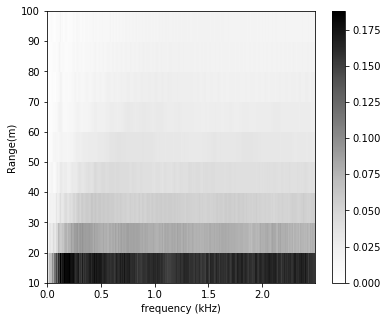

In [14]:
Height,D1,Eigen = map(float,[100,7,6])

D2_start,D2_end,D2_res = 1,5,11
D2_test = np.linspace(D2_start,D2_end,D2_res) #1cm increment
dummy_list = np.linspace(10,100,10)
EGC_multiple = []

for Range in dummy_list:
    freq_final_list, max_final_new_list, EGC = dynamicRangeFrequencyResponse(Height,Range,D1,Eigen,freq_list,D2_list=True,D2_test = D2_test,result = 'complete')
    EGC_multiple.append(EGC)

X,Y = np.meshgrid(freq_list, dummy_list)
Z = EGC_multiple

fig, ax = plt.subplots(figsize=(6, 5))

p = ax.pcolor(X, Y, Z, cmap=plt.cm.Greys, vmin=np.abs(Z).min(), vmax=np.abs(Z).max())
cb = fig.colorbar(p)
plt.xlabel("frequency (kHz)")
plt.ylabel("Range(m)")
plt.show(cb)

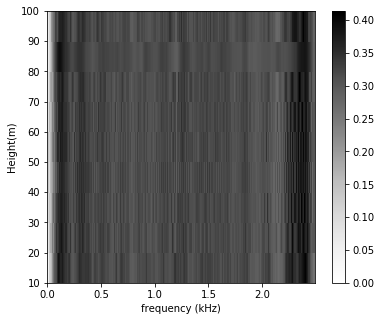

In [15]:
Range,D1,Eigen = map(float,[5,7,6])

D2_start,D2_end,D2_res = 1,5,11
D2_test = np.linspace(D2_start,D2_end,D2_res) #1cm increment
dummy_list = np.linspace(10,100,10)
EGC_multiple = []

for Height in dummy_list:
    freq_final_list, max_final_new_list,EGC = dynamicRangeFrequencyResponse(Height,Range,D1,Eigen,freq_list,D2_list=True,D2_test = D2_test,result = 'complete')
    EGC_multiple.append(EGC)

X,Y = np.meshgrid(freq_list, dummy_list)
Z = EGC_multiple

fig, ax = plt.subplots(figsize=(6, 5))

p = ax.pcolor(X, Y, Z, cmap=plt.cm.Greys, vmin=np.abs(Z).min(), vmax=np.abs(Z).max())
cb = fig.colorbar(p)
plt.xlabel("frequency (kHz)")
plt.ylabel("Height(m)")
plt.show(cb)

##### Couple ways to analyze spatial diversity:
1. average data points of a certain frequency bin and compare that to deltaD2 (looking at certain bin)
2. autocorrelation (the whole frequency response)
3. Minus one signal to another signal take the maximum, to see the maximum benefits of one signal over the other.
4. averaging (But this is not good)
5. Binary Disimilrity metric. take one signal as reference, and then if it is greater in magintude = 1, if lesser = 0. and then find the yule difference / hammering difference.
6. 

In [16]:
freq_list=np.arange(0.75,1.25,((1.25-0.75)/256))
#freq_list=np.arange(0,2.5,((2.5-0)/256))

D2_start,D2_end,D2_res = 4,5,2
D2_test = np.linspace(D2_start,D2_end,D2_res) 
Height,Range,D1,Eigen = 100,10,7,6
freq_final_list, max_final_new_list,EGC= dynamicRangeFrequencyResponse(Height,Range,D1,Eigen,freq_list,D2_list=True, D2_test = D2_test, result = 'complete')



roundD2_test = ['%.2f'% elem for elem in D2_test]
roundD2_test.append("EGC")
data = {'xs': freq_final_list,
        'ys': max_final_new_list,
        'labels': roundD2_test,
        'mypalette': Spectral11[0:len(D2_test)]+['#000000']}
#'#c70039'
source = ColumnDataSource(data)

FI = figure(x_axis_label = "Frequency(kHz)", y_axis_label = "Ampltidue",plot_width=950, plot_height=400,logo = None)
    #FI.line(freq_finallist,max_finalnew_list)
FI.title.text = 'Frequency Response of the Channel of range {0} m'.format(Range)
FI.title.align = "center"
FI.title.text_color = "black"
FI.title.text_font_size = "15px"

FI.multi_line(xs='xs', ys='ys', legend='labels', line_color = 'mypalette',source=source)

show(FI)



In the end, I will need to plot (Statistical Data vs The distance between two sensors.)

# Random Observations

###### Range vs Delay Spread
Delay Spread are usually caused by delay from the vertical distance of the channel.

It is observed that as the distance between the transmitter and reciever increase, the delay spread decreases exponentially. This is geometrically sounds, as the wider the channel, the eigen path needs to travel less vertical distance, hence less delay spread. 

In [17]:
i = 0
r_list = []
tao_list = []
samplefreq = 5.0*10**3 #Hz
freq = 2
Tx = CWsinewave(freq,T,num_samples)
Height,Dist1,Dist2 = 100,7,5
Range = 1
while Range < 4000: 
# Ray Modelling (non-recursive)
    ImpulseResponse(Tx,eigen,samplefreq,Height,Range,Dist1,Dist2)
    r_list.append(int(Range))
    #print(r_list)
    tao_list.append(tao)
    #print(tao_list)
    Range+=5

RD = figure(title="Range vs Delay Spread", x_axis_label = "range of the transmitter and receiver (m)", y_axis_label = "Delay Spread of the last eigen path (s)",plot_width=600, plot_height=300, logo = None)
RD.line(r_list,tao_list)
show(RD)

In [18]:
i = 0
h_list = []
tao_list = []
samplefreq = 5.0*10**3 #Hz
freq = 2
Tx = CWsinewave(freq,T,num_samples)
Range,Dist1,Dist2 = 100,7,5
Height = 1
while Range < 500: 
# Ray Modelling (non-recursive)
    ImpulseResponse(Tx,eigen,samplefreq,Height,Range,Dist1,Dist2)
    h_list.append(int(Height))
    #print(r_list)
    tao_list.append(tao)
    #print(tao_list)
    Height+=5

HD = figure(title="Height vs Delay Spread", x_axis_label = "height of the channel (m)", y_axis_label = "Delay Spread of the last eigen path (s)",plot_width=600, plot_height=300, logo = None)
HD.line(h_list,tao_list)
show(HD)

KeyboardInterrupt: 

In [ ]:
#Ray Modelling
split = 0
e,s,b = 0,0,0
tr = [0,r]
x = tr
dd = [d1,d2]
y = [d1,d2]
yi = [d1,d2]

X = []
Y = []

for j in range (int(eigen/3)+1):
    for i in range (3):
        if eigen == e:
            break
        split += 1
        
        if s==0 and b ==0:
            split = 0
            
        if s<b:
            split -= 1
        x = np.linspace(0,r,split+2)
        
        if s>b:
            y.insert(len(y)-1,h)
            yi.insert(len(yi)-1,0)
            
        if s == b and s!=0:
            y.insert(len(y)-1,0)
            yi.insert(len(yi)-1,h)
            
        X.append(x)
        Y.append(y)
        
        print("START POINT")
        print("s,b:", s,b)
        print ("split: ", split)
        print ("x points:   ", X)
        print("y points: ", Y)
        print("yinvert points: ", yi)
        print("END POINT")
        print(dd, tr)
# to change the s and b values
        if i == 0 or i == 2:
            s+= 1
        elif i == 1:
            s-= 1
            b+= 1

RM = figure(title = "Ray Modelling", x_axis_label = "range (m)", y_axis_label = "depth (m)",plot_width = 500, plot_height = 500, logo = None,toolbar_location = None)
RM.xgrid.grid_line_color = None
RM.ygrid.grid_line_color = None
left, right, bottom, top = 0-5, r+5, h, 0
RM.x_range=Range1d(left, right)
RM.y_range=Range1d(bottom, top)
numlines=eigen
mypalette=Spectral11[0:numlines]
RM.multi_line(X,Y,line_color=mypalette,line_width=0.5)
RM.asterisk(tr,dd, size=20, color="#F0027F")
show(RM)